<a href="https://www.kaggle.com/code/sharanharsoor/images-to-voice-with-ai?scriptVersionId=143435367" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction: 

In this evolving era of AI, we witness an array of tools lending a helping hand to humanity in various capacities. Within this article, we'll explore the process of transforming an image into speech. The constructed model comprehends the contents of the image, extracting pertinent details and converting them into text, which is then transformed into audible speech. This technology holds great potential, particularly in aiding the visually impaired - offering them a virtual 'eye'. Moreover, it can also be employed while driving, enabling your device to verbally convey the surroundings for enhanced safety.
At a higher level, the process of generating captions from images is facilitated by encoder-decoder models, specifically those integrating convolutional neural networks (CNN) and recurrent neural networks (RNN). The encoder segment applies various convolutions, max pooling, and fully connected layers to process the input image, ultimately producing a feature vector. <br>

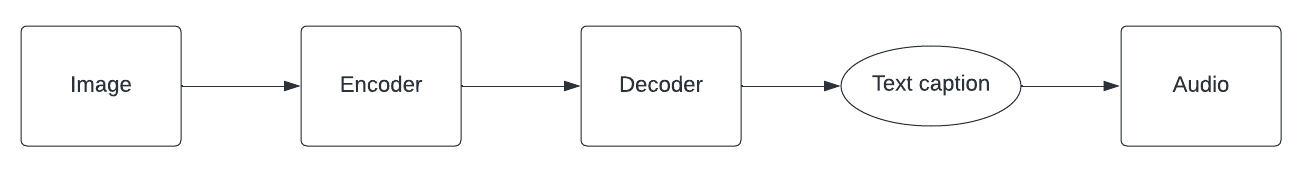 <br>

In [ ]:
# Import all the required libraries

from __future__ import print_function
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import glob
import cv2
import random as rd
import copy
import random
from PIL import Image
from tqdm.notebook import tqdm
from collections import Counter
from wordcloud import WordCloud
import spacy
import pickle 

%matplotlib inline


In [ ]:
! pip install pyttsx3

In [ ]:
! sudo apt install espeak -y

In [ ]:
def convert_to_audio(caption):
    engine = pyttsx3.init()
    engine.say(caption)
    engine.runAndWait()

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 2000)
pd.set_option('display.float_format', '{:20,.2f}'.format)
pd.set_option('display.max_colwidth', None)

In [ ]:
directory = '/kaggle/working/checkpoints/'
if not os.path.exists(directory):
    os.makedirs(directory)

In [ ]:
! cp -rf /kaggle/input/flickr8k/ /kaggle/working/

In [ ]:
! ls /kaggle/working/

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
# Define a distribution strategy
strategy = tf.distribute.MirroredStrategy()


# 1. Data understanding
The dataset utilized in this context is the publicly accessible Flickr 8K dataset, encompassing 8000 images capturing diverse scenarios and events. Each data entry is meticulously annotated with five captions. A significant advantage of employing this dataset lies in its compact size, enabling users to engage with it even on less powerful, low-end PCs.

In [ ]:
images='/kaggle/working/flickr8k/Images'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

In [ ]:
# taking 6 random images and display the same with the file name.

random.shuffle(all_imgs)
selected_imgs = all_imgs[:6]

# Create a subplot for each image
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    img_path = selected_imgs[i]
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')
    
    file_name = img_path.split('/')[-1] 
    ax.set_title(file_name)

plt.tight_layout()
plt.show()

In [ ]:
def load_doc(filename):
    try:
        with open(filename, 'r') as file:
            next(file)
            captions_doc = file.read()
        return captions_doc
    except FileNotFoundError:
        print(f"File '{filename}' not found.")
        return None


# Specify the correct file path
file_path = '/kaggle/working/flickr8k/captions.txt'
doc = load_doc(file_path)
print(doc[:300])

In [ ]:
print(len(doc))

In [ ]:
# mapping image to captions
# A single image have multiple description, in the mapping a single image file name with multiple descriptions are mapped
# for eg: '1000268201_693b08cb0e': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
#  'A girl going into a wooden building .',
# 'A little girl climbing into a wooden playhouse .',
#  'A little girl climbing the stairs to her playhouse .',
#  'A little girl in a pink dress going into a wooden cabin .'],
# print(len(mapping))  8091
# print(len(img_id_list)) 40455
# print(len(caption_list)) 40455

mapping = {}
img_id_list = []
image_path_list = []
caption_list = []

for line in tqdm(doc.split("\n")):
    #split the line with comma
    tokens = line.split(',')
    if len(line)<2:
        continue
        
    img_id , caption = tokens[0] , tokens[1:] 
    image_path_list.append('/kaggle/working/flickr8k/Images/' + img_id)
    # remove extensions from img id
    img_id = img_id.split('.')[0]
    img_id_list.append(img_id)
    caption_list.append(caption)
    
    # caption list to string
    caption = " ".join(caption)
    
    if img_id not in mapping:
        mapping[img_id] = []
    
    #store the captions
    mapping[img_id].append(caption)

In [ ]:
caption

In [ ]:
print(len(mapping))
print(len(img_id_list))
print(len(caption_list))
print(len(image_path_list))

In [ ]:
random.shuffle(all_imgs)
selected_imgs = all_imgs[:6]

# Create a subplot for each image
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    img_path = selected_imgs[i]
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')
    
    # Extract the file name from the path and display it below the image
    file_name = img_path.split('/')[-1]  # You may need to adjust the path separator if necessary
    file_name = os.path.splitext(file_name)[0]
    image_txt = mapping[file_name][0]
    ax.set_title(image_txt)

plt.tight_layout()
plt.show()

In [ ]:
# this is for reference.

all_img_id= img_id_list
all_img_vector= image_path_list
annotations= caption_list

df = pd.DataFrame(list(zip(all_img_id, all_img_vector, annotations)),columns =['ID','Path', 'Captions']) 

df.head()

In [ ]:
df.isnull().sum()

In [ ]:
#  Captions string is inside a list, removing the list.

df['Captions'] = df['Captions'].apply(lambda x: ' '.join(x))
df.head()

In [ ]:
df.isnull().sum()

In [ ]:
# Adding start and end tokens to each sentence. Later this will help in prediction. 

def add_tokens(captions):
    for i in range(len(captions)):
        # Take one caption at a time
        caption = captions[i]
        # Preprocessing steps
        # Add unique start and end tokens to the caption
        caption = '<start> ' + ' '.join([word for word in caption.split() if len(word) > 1]) + ' <end>'
        captions[i] = caption
    return captions

In [ ]:
#Create a list which contains all the captions
annotations= list(df['Captions'])
#add the <start> & <end> token to all those captions as well
annotations = add_tokens(annotations)

#Create a list which contains all the path to the images
all_img_path = image_path_list

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

In [ ]:
df['Captions'] = annotations
df.head(5)

In [ ]:
df.isnull().sum()

In [ ]:
# Create the vocabulary & the counter for the captions

vocabulary= [word for sentence in annotations for word in sentence.split()]

val_count=Counter(vocabulary)
val_count.most_common(5)

In [ ]:
print(len(val_count))

In [ ]:
# Visualise the top 30 occuring words in the captions

top_30_words = val_count.most_common(30)
words, counts = zip(*top_30_words)

# Create a bar chart to visualize the top 30 occurring words
plt.figure(figsize=(12, 6))
plt.bar(words, counts)
plt.xlabel('Words')
plt.ylabel('Count')
plt.title('Top 30 Occurring Words in Sentences')
plt.xticks(rotation=90)
plt.tight_layout()

# Show the plot
plt.show()


# 2. Pre-Processing the captions
Pre-processing in NLP/Deep Learning readies text data for effective analysis. It involves tokenization, breaking text into units like words, essential for models to understand structure. Uncommon words are replaced with "UNK" to simplify vocabulary and save memory. Creating word-to-index and index-to-word mappings enables numerical processing. Padding sequences to a uniform length ensures compatibility with neural networks. These steps collectively transform the raw text into a format that models can learn from, setting the foundation for various NLP tasks while optimizing memory usage and computational resources.

1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [ ]:
# create the tokenizer
# using preprocessing.text.Tokenizer from tenrfloe to tokenize the words. It will create words (english) to numeric representation.
# filter_chars arguments to Tokenizer makes sure to exculde them during tokenization.
# ovv_token (out-of-vocabulary): tokenize a new text that contains words not present in the learned vocabulary words to "<unk>"
# Eg: english sentence : ['<start> child in pink dress is climbing up set of stairs in an entry way <end>'] tokenized to 
# [2, 43, 4, 91, 173, 7, 120, 51, 394, 12, 395, 4, 28, 1, 671, 3]

top_word_count = 5000

filter_chars = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ '
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_word_count,
                                                  oov_token="<unk>",
                                                  filters=filter_chars)
tokenizer.fit_on_texts(annotations)
train_seqs = tokenizer.texts_to_sequences(annotations)
print(train_seqs[:5])
print(annotations[:5])
print(f'OOV Token: {tokenizer.oov_token}')

In [ ]:
# Create word-to-index and index-to-word mappings.
# word_index: contains words to numeric representation.[eg : 'the': 5, 'is': 7]
# index_word: contains numeric to words representation.[eg : 5: 'the', 7: 'is']

word_index = tokenizer.word_index
index_word = tokenizer.index_word

# Add Pad Token
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'


In [ ]:
! ls /kaggle/working/

In [ ]:
## Save Tokenizer,in case if we want to read it back from disk.
import pickle

with open('/kaggle/working/checkpoints/tokenizer.pkl',"wb") as f:
    pickle.dump(tokenizer,f)

In [ ]:
i = 0
for k, v in index_word.items():
    print(k, v)
    if(i ==8):
        break
    else:
        i += 1


In [ ]:
i = 0
for k, v in word_index.items():
    print(k, v)
    if(i ==8):
        break
    else:
        i += 1


In [ ]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing

word_counts = {word: count for word, count in tokenizer.word_counts.items() if word != "<unk>"}

# Sort the word counts in descending order
sorted_word_counts = dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True))

# Extract the top 30 words and their counts
top_30_words = list(sorted_word_counts.items())[:30]

# Extract words and counts from the top 30
words, counts = zip(*top_30_words)

# Create a bar chart to visualize the top 30 occurring words
plt.figure(figsize=(12, 6))
plt.bar(words, counts)
plt.xlabel('Words')
plt.ylabel('Count')
plt.title('Top 30 Occurring Words after Text Processing')
plt.xticks(rotation=90)
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# Pad each vector to the max_length of the captions ^ store it to a vairable
# max length of a caption is 35 and append the word <pad> if any of the senetence is less than 30. 
# keras.preprocessing.sequence.pad_sequences from tensorflow would help to do that.

max_sequence_len = max(len(t) for t in train_seqs)
print(f'Max Sequence Length of the Texts is: {max_sequence_len}')

cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post', maxlen=max_sequence_len)
print("The shape of Caption vector is :" + str(cap_vector.shape))

In [ ]:
# printing all details about captions that are performed so far.

print("Vocabulary size:", len(val_count))
print("Word-to-index mapping:", len(word_index))
print("Index-to-word mapping:", len(index_word))
print("len Captions (padded):\n", len(cap_vector))
print("len[0] Captions (padded):\n", len(cap_vector[0]))
print(" 1st Captions (padded):\n", cap_vector[0])
print("Captions (padded):\n", cap_vector)

# 3. Image Feature Vector Construction:

The objective is to extract image features (weights) from a pre-trained model, which will then serve as input for the encoder in an RNN model tasked with generating captions. Specifically, the inception_v3 pre-trained model is employed for this purpose. Since pre-trained models have specific requirements regarding image size and shape, this code segment handles the necessary pre-processing steps to meet those specifications.

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

In [ ]:
# for capturing image features, we will use the pre-trained model inception_v3. this model expects input images to be in the share (299, 299) and
# image value range from -1 to +1. the same operation is performed in the below function preprocess_image.
# Size of image before preprocessing: (500, 375, 3)
# Size of image after preprocessing: (299, 299, 3)
# Note : preprocess_image function returns the resized image along with it's path. 
 
# write your code here to create the dataset consisting of image paths

#image_paths = df['Path'].values
#image_paths_dataset = tf.data.Dataset.from_tensor_slices(image_paths)

def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

# Check the preprocessing Logic
print(f'Size of image before preprocessing: {mpimg.imread(all_img_vector[0]).shape}')
print(f'Size of image after preprocessing: {preprocess_image(all_img_vector[0])[0].shape}')


In [ ]:
# write your code here for applying the function to the image path dataset, such that the transformed dataset should contain images & their path
# we need to pre-process all the images before feeding them to inception_v3 model and also create a dataset out of the same.
# to create a dataset tensorflow function from_tensor_slices would do that and to speed up the process parallelly. 
# with batch(64), the groups consecutive elements of the dataset into batches of size 64.

unique_img_vector = sorted (set(all_img_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(unique_img_vector)
image_dataset = image_dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
                .batch(64)
image_dataset


## Load the pretrained Imagenet weights of Inception net V3

In [ ]:
# we will load the InceptionV3 model include_top=False means that we're excluding the fully connected layers at the top of the network, which are typically used for classification. 
# weights='imagenet' specifies that the model should be loaded with pre-trained ImageNet weights.
# image_model.input gives you the input tensor of the InceptionV3 model. This will be a placeholder for the input images.
# image_model.layers[-1] retrieves the last layer of the InceptionV3 model, which in this case is the last convolutional layer.
# .output retrieves the output tensor of that layer. This tensor will contain features extracted from the images. The shape of the output of this layer is 8x8x2048.
# Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)
# tf.keras.Model(new_input, hidden_layer): This line creates a new model, which is a modified version of the original InceptionV3 model.
# It takes the same input as the original model but outputs the tensor from the last convolutional layer.
# the new model code can also be written as tf.keras.Model(image_model.input, image_model.layers[-1].output)
# This new model is designed for feature extraction. It will take an image as input and output the features extracted by the InceptionV3 model.

image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

new_input = image_model.input #write code here to get the input of the image_model
hidden_layer = image_model.layers[-1].output #write code here to get the output of the image_model

image_features_extract_model = tf.keras.Model(new_input, hidden_layer) #build the final model using both input & output layer


In [ ]:
# image_features_extract_model.summary()

In [ ]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)
# This line reshapes the batch_features tensor. It changes the shape to have the same number of samples in the batch, but the second dimension is 
# flattened. The new shape is (batch_size, -1, num_features), where batch_size is the number of images in the batch, 
# and num_features is the number of extracted features.
# The use of -1 in the second dimension allows TensorFlow to automatically calculate the size of that dimension 
# based on the other dimensions, ensuring that the reshaping is compatible.
# This reshaping would help in further feeding it into a next model for processing and predicting the text. 
# the image 1000268201_693b08cb0e.jpg  is converted to numpy feature store to 1000268201_693b08cb0e.jpg.npy. Same is done to all the images.
# Overall, this code processes batches of preprocessed images, extracts features using the modified InceptionV3 model, and saves
# these features as NumPy arrays with filenames corresponding to the original image files. This can be useful for later stages of a 
# machine learning pipeline, such as training a model using these features.

for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
    
    
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())


In [ ]:
# !ls /kaggle/working/flickr8k/Images

# 4. Dataset creation
The division of training and testing data has been completed, which includes paths to the images in the training set and their associated captions. Previously, we stored the features of each image in a numpy array. To facilitate further model training, we need to retrieve these stored features and convert them into a TensorFlow dataset. The 'map_func' function accomplishes this by loading the previously saved features from the disk and returning the image tensor along with its caption. The 'gen_dataset' function utilizes 'map_func' to create a dataset. The output shape of the image features in the dataset is (64, 64, 2048) with a batch size of 64, while the captions have a shape of (64, 35).

In [ ]:
path_train, path_test, cap_train, cap_test = train_test_split(all_img_vector, cap_vector, test_size=0.2, random_state=42)

In [ ]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

In [ ]:
# Define a function 'map_func' that takes an image path and caption as inputs.
# It decodes the image path using UTF-8, appends '.npy', and loads it as an image tensor.
# The function then returns a tuple containing the image tensor and the original caption.

def map_func(image, caption):
    img_tensor = np.load(image.decode('utf-8')+'.npy')
    return img_tensor,caption

the devide of train and test is done and that contains path for the images of the train and captions associated with them. 
earlier we have stored the features of each image in the numpy array. For further training of the model, we need to fetch these stored feature into 
tensorflow dataset. For that the fucntion 'map_func' loads the previously saved features from disk and returns the image tensor and the caption.
gen_dataset is a function that creates a dataset by using the map_func. 
The shape of the output of dataset of image features is (64, 64, 2048) (batch_size is 64)
captions shape (64, 35)


In [ ]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier
# # This function should transform the created dataset(img_path,cap) to 
# (features,cap) using the map_func created earlier

def gen_dataset(image, caption, batch_size = 32, buffer_size=1000):
    
    dataset = tf.data.Dataset.from_tensor_slices((image, caption))

    # Use map to load the numpy files in parallel
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
            map_func, [item1, item2], [tf.float32, tf.int32]),
            num_parallel_calls=tf.data.AUTOTUNE)

    # Shuffle and batch
    dataset = dataset.shuffle(buffer_size).batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

In [ ]:
BATCH_SIZE = 64

train_dataset = gen_dataset(path_train, cap_train, BATCH_SIZE)
test_dataset = gen_dataset(path_test, cap_test, BATCH_SIZE)

In [ ]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  # (batch_size, 8*8, 2048)
print(sample_cap_batch.shape) # (batch_size,max_len)

In [ ]:
# sample_img_batch

# 5. Model Architecture:
The CNN-based encoder generates a fixed feature vector, representing the input image's encoded information. This feature vector remains constant across all timestamps. It's combined with the decoder's hidden state to form the context vector in the attention model.
<br>
On the decoder side, the input sequence is pre-processed and standardized to have equal sequence lengths. This processed sequence is then passed through an embedding layer to create embedded vectors. These embeddings are concatenated with the context vector from the attention model and fed into a concatenation layer.
<br>
The output of this concatenation layer serves as input for the GRU, a type of RNN. The GRU produces an output and a hidden state, which are used at the subsequent timestep. A dense layer follows the GRU, performing a linear transformation on the previous output. This yields a list of probability values for all words in the vocabulary, with the word having the highest probability chosen as the prediction for that timestep.


In [ ]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(path_train) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE


# 6. Model Building:

### Encoder

In [ ]:
# this is for the encoder class where input features extracted from the image i.e 64(8*8)*2048 is fed to dense layer. the dense layer mapping 
# will be from 2048 to 256. 
# output of each image will be 64(8*8) * 256 (with batch size of 64, so output is 64*64*256).

class Encoder(tf.keras.Model):
    def __init__(self,embed_dim = 256):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim) # build your Dense layer with relu activation
        
    def call(self, features):
        features =  self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        features = tf.nn.relu(features)
        return features

In [ ]:
encoder = Encoder(embedding_dim)

### Attention model

In [ ]:
# attention is called from decoder.

class Attention_model(tf.keras.Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units) #build your Dense layer, number of units is 512
        self.W2 = tf.keras.layers.Dense(units) #build your Dense layer, number of units is 512
        self.V = tf.keras.layers.Dense(1) #build your final Dense layer with unit 1
        self.units=units
        
#features.shape (64, 64, 256)
#hidden.shape (64, 512)
#hidden_with_time_axis.shape (64, 1, 512)
#attention_hidden_layer.shape (64, 64, 512)
#score.shape (64, 64, 1)
#attention_weights.shape (64, 64, 1)
#1 context_vector.shape (64, 64, 256)
#2 context_vector.shape (64, 256)


    def call(self, features, hidden):
        #print("features.shape",features.shape)
        #print("hidden.shape",hidden.shape)

        # feature variable is nothing but output from encoder with shape batch_size, 8*8, embedding_dim. (64*64*256)
        # hidden variable output init state from decoder hidden_size (64 * 512)
        hidden_with_time_axis =  tf.expand_dims(hidden,1) # Expand the hidden shape to : (batch_size, 1, hidden_size)
        #print("hidden_with_time_axis.shape",hidden_with_time_axis.shape)
        # This line expands the dimensions of the hidden tensor. It adds an extra dimension at index 1. This is done to match the shape of the features for subsequent operations.
        # attention_hidden_layer shape == (batch_size, 64, units)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                            self.W2(hidden_with_time_axis))) # [(64, 1, 512) + (64, 64, 512)]  =  (64, 64, 512)
        #print("attention_hidden_layer.shape",attention_hidden_layer.shape)
        score = self.V(attention_hidden_layer) # build your score funciton to shape: (batch_size, 8*8, units) (64, 64, 1)
        #print("score.shape",score.shape)
        attention_weights =  tf.nn.softmax(score, axis=1) # extract your attention weights with shape: (batch_size, 8*8, 1) (64, 64, 1)
        #print("attention_weights.shape",attention_weights.shape)
        context_vector =  attention_weights * features # shape: context vector (batch_size, 8*8,embedding_dim) (64*64*1)*(64, 64, 256) = (64, 64, 256)
        #print("1 context_vector.shape",context_vector.shape)
        context_vector =  tf.reduce_sum(context_vector, axis=1) # reduce the shape to (batch_size, embedding_dim) (64, 256)
        #print("2 context_vector.shape",context_vector.shape)

        return context_vector, attention_weights

how attention_weights are used? Answer here

### Decoder

In [ ]:
# Decoder model

class Decoder(tf.keras.Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units) #iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embedding_dim)#build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units)#build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size)#build your Dense layer
        
    '''
x.shape (64, 1)
features.shape (64, 64, 256)
hidden.shape (64, 512)
embed.shape 1 (64, 1, 256)
embed.shape 2 (64, 1, 512)
output.shape  (64, 1, 512)
state.shape   (64, 512)
output.shape 1   (64, 1, 512)
output.shape 2  (64, 512)
output.shape 3  (64, 5001)
    '''
    def call(self, x, features, hidden):
        #print("x.shape",x.shape)
        #print("features.shape",features.shape)
        #print("hidden.shape",hidden.shape)

        context_vector, attention_weights = self.attention(features, hidden) # create your context vector & attention weights from attention model
        embed =  self.embed(x)# embed your input to shape: (batch_size, 1, embedding_dim)
        #print("embed.shape 1",embed.shape)
        embed =  tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        #print("embed.shape 2",embed.shape)
        output,state = self.gru(embed)# Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        #print("output.shape ",output.shape)
        #print("state.shape  ",state.shape)

        output = self.d1(output)
        #print("output.shape 1  ",output.shape)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        #print("output.shape 2 ",output.shape)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        #print("output.shape 3 ",output.shape)
        return output, state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))


In [ ]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [ ]:
# predictions from Decoder is equal to size of vocabulary (later highest valued word can be taken from list).

features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size = sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1) # you just send <start> keyword to start the prediction
# after multiplying with batch, so entire batch size can be sent.

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

# 7. Model Training.

In [ ]:
optimizer = tf.keras.optimizers.Adam() #define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')#define your loss object

In [ ]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)


In [ ]:
checkpoint_path = os.path.join("checkpoints","train")
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [ ]:
with strategy.scope():

    @tf.function
    def train_step(img_tensor, target):
        loss = 0
        hidden = decoder.init_state(batch_size=target.shape[0])
        dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

        with tf.GradientTape() as tape:
            #write your code here to do the training steps
            features = encoder(img_tensor)
            for i in range(1,target.shape[1]): # we want to predict till we reach the same number of words as target has. 
                predictions,hidden,_ = decoder(dec_input, features, hidden)
                loss += loss_function(target[:,i], predictions)
                # using teacher forcing
                dec_input = tf.expand_dims(target[:, i], 1)

            avg_loss = (loss / int(target.shape[1]))
            trainable_variables = encoder.trainable_variables + decoder.trainable_variables
            gradients = tape.gradient(loss, trainable_variables)
            optimizer.apply_gradients(zip(gradients, trainable_variables))
            '''
            These lines perform backpropagation to update the model's weights.

            It first concatenates the trainable variables of both the encoder and decoder.

            Then, it computes the gradients of the loss with respect to these variables.

            Finally, it applies the computed gradients using an optimizer.

            '''

        return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [ ]:
with strategy.scope():

    @tf.function
    def test_step(img_tensor, target):
        loss = 0
        hidden = decoder.init_state(batch_size=target.shape[0])
        dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

        with tf.GradientTape() as tape:
        #write your code here to do the training steps
            features = encoder(img_tensor)
            for i in range(1,target.shape[1]):
                predictions,hidden,_ = decoder(dec_input,features,hidden)
                loss += loss_function(target[:,i], predictions)
                predicted_id = tf.argmax(predictions,1)
                dec_input = tf.expand_dims(predicted_id, 1)

        avg_loss = (loss / int(target.shape[1]))

        return loss, avg_loss


In [ ]:
def test_loss_cal(test_dataset):
    total_loss = 0

    for (batch,(img_tensor,target)) in enumerate(test_dataset):
        batch_loss,t_loss = test_step(img_tensor,target)
        total_loss += t_loss
    return total_loss/test_num_steps


### Train Loop

In [ ]:
import time
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps

    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)

    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()


In [ ]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE: 
The presence of teacher forcing leads to a distinction between the train and test steps, resulting in a scenario where the train loss is decreasing while the test loss is not being reduced. It should be noted that in this context, a direct comparison between train and test results is not applicable, as the approaches used for each are distinct. This does not imply overfitting of the model

# 8.  Model Evaluation
For this project, we will employ two methods to assess the model: greedy search and beam search. We will conduct testing with sample data and evaluate using the BLEU score.
Greedy Search:
Greedy search is a decoding algorithm commonly used in Natural Language Processing (NLP) for generating sequences, such as sentences or translations.
It works by selecting the most probable next word at each step of sequence generation based on the probability distribution predicted by the model.
Greedy search is computationally efficient as it only considers the most likely option at each step. However, it may lead to suboptimal results since it doesn't consider future context.

Beam Search:
Beam search is another decoding algorithm used in NLP, especially in tasks like machine translation or text generation.
Unlike greedy search, beam search keeps track of multiple candidate sequences (known as the "beam width") at each step. It explores a broader range of possibilities.
At each step, it scores and keeps the top candidates based on their likelihood. This allows beam search to consider a wider context and potentially find better sequences compared to greedy search.

BLEU Score:
BLEU (Bilingual Evaluation Understudy) is a metric used to evaluate the quality of machine-translated text. It can also be used for other NLP tasks like text summarization and generation.
BLEU measures the similarity between a generated text and one or more reference texts (human-generated). It does this by comparing n-grams (sequences of n words) in the generated and reference texts.
The BLEU score ranges from 0 to 1, where higher scores indicate better agreement with the reference texts. However, it's important to note that BLEU is not always a perfect indicator of the quality of the generated text, and it has its limitations.

### Greedy Search

In [ ]:
attention_features_shape = 64

def evaluate(image):
    attention_plot = np.zeros((max_sequence_len, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(preprocess_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input)# Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)# extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_sequence_len):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)# get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy() # extract the predicted id(embedded value) which carries the max value
        result.append(tokenizer.index_word[predicted_id])
        #map the id to the word from tokenizer and append the value to the result list

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot, predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot, predictions


### Beam Search

In [ ]:
def beam_evaluate(image, beam_index = 3):

    #write your code to evaluate the result using beam search
    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_sequence_len, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(preprocess_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < max_sequence_len:
        temp = []
        for i, s in enumerate(result):
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            word_preds = np.argsort(predictions[0])[-beam_index:]

            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)

                prob += np.log(predictions[0][w])

                temp.append([next_cap, prob])
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]


        predicted_id = result[-1]
        pred_list = predicted_id[0]

        prd_id = pred_list[-1]
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)  
        else:
            break


    result2 = result[-1][0]

    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)

        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])
    return final_caption


In [ ]:
test_image = "/kaggle/working/flickr8k/Images/3106883334_419f3fb16f.jpg"
captions=beam_evaluate(test_image)
print(captions)
Image.open(test_image)

In [ ]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8)) # This line reshapes the attention weights associated with the current word. It is assumed that each set of weights corresponds to an 8x8 grid. as we have maintained 8*8 since the start.
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS)) #This resizes the attention weights image to be compatible with the size of the original image. It uses the Lanczos resampling method for high-quality resizing.
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [ ]:
captions=beam_evaluate(test_image)
print(captions)

In [ ]:
def test_caption_generation(img_test):


    rid = np.random.randint(0, len(img_test))
    test_image = img_test[rid]
    #test_image = './images/413231421_43833a11f5.jpg'
    #real_caption = '<start> black dog is digging in the snow <end>'

    real_caption = ' '.join(
        tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]
    )

    result, attention_plot, pred_test = evaluate(test_image)


    real_caption=filt_text(real_caption)      


    pred_caption=' '.join(result).rsplit(' ', 1)[0]

    real_appn = [real_caption.split()]
    reference = real_appn
    candidate = pred_caption.split()

    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', pred_caption)
    
    # to audio
    #convert_to_audio(pred_caption)
    
    score1 = sentence_bleu(reference, candidate, weights=(1,0,0,0))
    score2 = sentence_bleu(reference, candidate, weights=(0,1,0,0))
    score3 = sentence_bleu(reference, candidate, weights=(0,0,1,0))
    score4 = sentence_bleu(reference, candidate, weights=(0,0,0,1))
    print("\nBELU score: ")
    print(f"Individual 1-gram: {score1*100}")
    print(f"Individual 2-gram: {score2*100}")
    print(f"Individual 3-gram: {score3*100}")
    print(f"Individual 4-gram: {score4*100}")

    plot_attmap(result, attention_plot, test_image)


    Image.open(test_image)


In [ ]:
test_caption_generation(path_test)

In [ ]:
def Prediction_Unknown_data(test_image):
    #Testing on test image
    openImg = test_image
    result, attention_plot,pred_test = evaluate(test_image)
    pred_caption=' '.join(result).rsplit(' ', 1)[0]

    candidate = pred_caption.split()

    print ('Prediction Caption:', pred_caption)
    print ('')
    newsize = (800, 800)
    im = Image.open(openImg).resize(newsize)
    width, height = im.size
    print(width,height)
    div=3
    if width > 3000:
        div=10
    im = im.resize((width//div, height//div))
    
    return im
    


In [ ]:
Prediction_Unknown_data(path_test[30])

# end